In [83]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
import sklearn, re
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [130]:
winBids = (pd.read_csv("data/winning_bids.csv")
        .drop(["auction_id", "pre_auction_csa_flag", "post_auction_csa_flag"],axis=1)
        .rename({'bidder_as_of_closing_pn':"bidder", "frn_as_of_closing_pn":"frn"}, axis=1)
)

winBids.head()

,call_sign,facility_id,dma,bidder,frn,pre_auction_band,winning_bid_option,compensation
0,WCDC-TV,74419,"Albany-Schenectady-Troy, NY","NEXSTAR BROADCASTING, INC.",9961889,UHF,Go off-air,34558086
1,WAGT,70699,"Augusta, GA","Gray Television Licensee, LLC",3748241,UHF,Go off-air,40763036
2,WUTB,60552,"Baltimore, MD","Deerfield Media (Baltimore) Licensee, LLC",22739833,UHF,Go off-air,122912964
3,WBIN-TV,14682,"Boston, MA","WBIN, Inc.",20871042,UHF,Go off-air,68081337
4,WDPX-TV,6476,"Boston, MA","ION Media Boston License, Inc.",3720208,UHF,Go off-air,43467644


In [131]:
winBids.dma = winBids.dma.str.upper()
winBids["dmaLocal"] = winBids.dma.apply(lambda x: x.split("-")[0].split(",")[0])
winBids.head()

,call_sign,facility_id,dma,bidder,frn,pre_auction_band,winning_bid_option,compensation,dmaLocal
0,WCDC-TV,74419,"ALBANY-SCHENECTADY-TROY, NY","NEXSTAR BROADCASTING, INC.",9961889,UHF,Go off-air,34558086,ALBANY
1,WAGT,70699,"AUGUSTA, GA","Gray Television Licensee, LLC",3748241,UHF,Go off-air,40763036,AUGUSTA
2,WUTB,60552,"BALTIMORE, MD","Deerfield Media (Baltimore) Licensee, LLC",22739833,UHF,Go off-air,122912964,BALTIMORE
3,WBIN-TV,14682,"BOSTON, MA","WBIN, Inc.",20871042,UHF,Go off-air,68081337,BOSTON
4,WDPX-TV,6476,"BOSTON, MA","ION Media Boston License, Inc.",3720208,UHF,Go off-air,43467644,BOSTON


In [87]:
dmaByBids = (winBids
            .pivot_table(index="bidder", values="dma", aggfunc="count", margins=True)
            .sort_values("dma", ascending=False))
dmaByBids.head()

,dma
bidder,
All,175
"NEXSTAR BROADCASTING, INC.",10
"OTA Broadcasting (PIT), LLC",5
"Entravision Holdings, LLC",4
"Trinity Christian Center of Santa Ana, Inc.",4


In [127]:
dmaZip = (pd.read_csv("data/dma_to_zipcode.csv")
        .rename({"dma_description":"dma", 
        "zip_code":"zipcode"}, axis=1)
        [['zipcode', 'dma']]
        .pivot_table(index="dma", aggfunc="max", margins=True)
        .reset_index())

dmaZip["dmaLocal"]= (dmaZip.dma.apply(lambda x: x.split("-")[0].split(",")[0]))

dmaZip.head()

,dma,zipcode,dmaLocal
0,ABILENE - SWEETWATER,79699,ABILENE
1,ALBANY - SCHENECTADY - TROY,13470,ALBANY
2,"ALBANY, GA",39885,ALBANY
3,ALBUQUERQUE - SANTA FE,88439,ALBUQUERQUE
4,"ALEXANDRIA, LA",71496,ALEXANDRIA


In [108]:
bidZip = (winBids.merge(dmaZip, on="dmaLocal", how = "left")
            .dropna(axis=0)
            .drop(["dma_y"], axis=1)
            .rename({"dma_x":"dma"}, axis=1)
)
bidZip.head()

pandas.core.series.Series

In [90]:
bidsByDma = (bidZip.pivot_table(index="zipcode", values="bidder", 
                aggfunc="count")
            .sort_values("bidder", ascending=False)
            .reset_index())
            
bidsByDma.zipcode = bidsByDma.zipcode.astype(int)
bidsByDma.set_index("zipcode", inplace=True)

bidsByDma.head(10)

,bidder
zipcode,
93599,12
18464,10
19980,10
26764,8
26865,8
61373,6
53963,4
47997,3
45859,3


In [128]:
census = pd.read_csv('data/census_zip.csv')
census.tail()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
166447,56,WY,99999,2,3490.0,2010.0,940.0,440.0,3290.0,70.0,...,0.0,0.0,440.0,590.0,2930.0,8141.0,2880.0,7855.0,50.0,86.0
166448,56,WY,99999,3,2350.0,1030.0,1080.0,200.0,2220.0,50.0,...,0.0,0.0,460.0,947.0,1800.0,5772.0,1720.0,5164.0,70.0,257.0
166449,56,WY,99999,4,1700.0,530.0,1080.0,100.0,1630.0,30.0,...,0.0,0.0,410.0,1052.0,1230.0,4529.0,1160.0,4188.0,50.0,139.0
166450,56,WY,99999,5,2560.0,420.0,2080.0,80.0,2470.0,40.0,...,0.0,0.0,820.0,3897.0,1660.0,8677.0,1480.0,7299.0,200.0,1036.0
166451,56,WY,99999,6,830.0,160.0,700.0,0.0,850.0,0.0,...,510.0,3685.0,390.0,12002.0,400.0,18594.0,170.0,2893.0,230.0,13413.0


In [92]:
def toMoney(series):
    if series == 1:
        return 25000
    if series == 2:
        return 50000
    if series == 3:
        return 75000
    if series == 4:
        return 100000
    if series == 5:
        return 200000
    if series == 6:
        return 250000

census["income"] = census["agi_stub"].apply(toMoney)

for c in census.columns:
    if "MAR" in c or "mar" in c or "1" in c or "0" in c \
        or "5" in c or "F" in c or "R" in c or "VITA" in c \
        or "N" in c or "TCE" in c:
            census.drop(c, axis = 1, inplace=True)

census.head()

,STATE,zipcode,agi_stub,income
0,AL,0,1,25000
1,AL,0,2,50000
2,AL,0,3,75000
3,AL,0,4,100000
4,AL,0,5,200000


In [93]:
censusByZip = (census.pivot_table(index="zipcode", aggfunc="max")
                .reset_index()
)
censusByZip.head()

,zipcode,STATE,agi_stub,income
0,0,WY,6,250000
1,1001,MA,6,250000
2,1002,MA,6,250000
3,1005,MA,6,250000
4,1007,MA,6,250000


In [94]:
bidZipInc = (bidZip.merge(censusByZip, on="zipcode", how="left")
            .dropna(axis=0)
)
bidZipInc.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,bidder,frn,pre_auction_band,winning_bid_option,compensation,dmaLocal,zipcode,STATE,agi_stub,income
6,66190,BLEDT20040323ATV,WPBO,43,PORTSMOUTH,OH,DT,20070.9,19076.9,620060,...,THE OHIO STATE UNIVERSITY,6031983,UHF,Go off-air,8822670,CHARLESTON,29929.0,SC,6.0,250000.0
7,67798,BLCDT20080512AEM,WTSF,44,ASHLAND,KY,DT,11260.7,10475.1,542754,...,"Tri State Family Broadcasting, Inc",2011948,UHF,Move to High-VHF,5540044,CHARLESTON,29929.0,SC,6.0,250000.0
8,60888,BLANK0000001556,WLNN-CD,24,BOONE,NC,DC,11130.2,6927.9,358869,...,Carolina Rays LLC,18324095,UHF,Go off-air,21321125,CHARLOTTE,29745.0,SC,6.0,250000.0
9,20624,BLANK0000001541,WMYT-TV,39,ROCK HILL,SC,DT,34721.7,30402.3,3394886,...,"Fox Television Stations, LLC",5795067,UHF,Go off-air,74739363,CHARLOTTE,29745.0,SC,6.0,250000.0
10,54983,BLDTA20120628ABE,WTBL-CD,49,LENOIR,NC,DC,6862,5742.8,417903,...,"OTA Broadcasting (CLT), LLC",21349188,UHF,Go off-air,8193916,CHARLOTTE,29745.0,SC,6.0,250000.0


In [125]:
popZip = (pd.read_csv("data/pop_zip.csv")[["zipcode", 'population']]
        .eval('population = population * 1000')
        .groupby("zipcode").mean())

popZip.population = popZip.population.astype(int)

popZip.head()

,population
zipcode,
602,2542040
603,3348306
606,405000
610,1776489
612,4102653


In [96]:
bidZipIncPop = (bidZipInc.merge(popZip, on="zipcode", how="left")
                .dropna(axis=0))
bidZipIncPop.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,frn,pre_auction_band,winning_bid_option,compensation,dmaLocal,zipcode,STATE,agi_stub,income,population
0,66190,BLEDT20040323ATV,WPBO,43,PORTSMOUTH,OH,DT,20070.9,19076.9,620060,...,6031983,UHF,Go off-air,8822670,CHARLESTON,29929.0,SC,6.0,250000.0,69489
1,67798,BLCDT20080512AEM,WTSF,44,ASHLAND,KY,DT,11260.7,10475.1,542754,...,2011948,UHF,Move to High-VHF,5540044,CHARLESTON,29929.0,SC,6.0,250000.0,69489
2,60888,BLANK0000001556,WLNN-CD,24,BOONE,NC,DC,11130.2,6927.9,358869,...,18324095,UHF,Go off-air,21321125,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551
3,20624,BLANK0000001541,WMYT-TV,39,ROCK HILL,SC,DT,34721.7,30402.3,3394886,...,5795067,UHF,Go off-air,74739363,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551
4,54983,BLDTA20120628ABE,WTBL-CD,49,LENOIR,NC,DC,6862,5742.8,417903,...,21349188,UHF,Go off-air,8193916,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551


In [97]:
bidZipIncPop.eval("pop_by_income = population * income", inplace=True)
bidZipIncPop.pop_by_income = bidZipIncPop.pop_by_income.astype(int)
bidZipIncPop.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,pre_auction_band,winning_bid_option,compensation,dmaLocal,zipcode,STATE,agi_stub,income,population,pop_by_income
0,66190,BLEDT20040323ATV,WPBO,43,PORTSMOUTH,OH,DT,20070.9,19076.9,620060,...,UHF,Go off-air,8822670,CHARLESTON,29929.0,SC,6.0,250000.0,69489,17372250000
1,67798,BLCDT20080512AEM,WTSF,44,ASHLAND,KY,DT,11260.7,10475.1,542754,...,UHF,Move to High-VHF,5540044,CHARLESTON,29929.0,SC,6.0,250000.0,69489,17372250000
2,60888,BLANK0000001556,WLNN-CD,24,BOONE,NC,DC,11130.2,6927.9,358869,...,UHF,Go off-air,21321125,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551,442637750000
3,20624,BLANK0000001541,WMYT-TV,39,ROCK HILL,SC,DT,34721.7,30402.3,3394886,...,UHF,Go off-air,74739363,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551,442637750000
4,54983,BLDTA20120628ABE,WTBL-CD,49,LENOIR,NC,DC,6862,5742.8,417903,...,UHF,Go off-air,8193916,CHARLOTTE,29745.0,SC,6.0,250000.0,1770551,442637750000


In [98]:
bidZipIncPop = (bidZipIncPop.drop(["agi_stub", "STATE", "dmaLocal"],axis=1)
)
bidZipIncPop.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,dma,bidder,frn,pre_auction_band,winning_bid_option,compensation,zipcode,income,population,pop_by_income
0,66190,BLEDT20040323ATV,WPBO,43,PORTSMOUTH,OH,DT,20070.9,19076.9,620060,...,"CHARLESTON-HUNTINGTON, WV",THE OHIO STATE UNIVERSITY,6031983,UHF,Go off-air,8822670,29929.0,250000.0,69489,17372250000
1,67798,BLCDT20080512AEM,WTSF,44,ASHLAND,KY,DT,11260.7,10475.1,542754,...,"CHARLESTON-HUNTINGTON, WV","Tri State Family Broadcasting, Inc",2011948,UHF,Move to High-VHF,5540044,29929.0,250000.0,69489,17372250000
2,60888,BLANK0000001556,WLNN-CD,24,BOONE,NC,DC,11130.2,6927.9,358869,...,"CHARLOTTE, NC",Carolina Rays LLC,18324095,UHF,Go off-air,21321125,29745.0,250000.0,1770551,442637750000
3,20624,BLANK0000001541,WMYT-TV,39,ROCK HILL,SC,DT,34721.7,30402.3,3394886,...,"CHARLOTTE, NC","Fox Television Stations, LLC",5795067,UHF,Go off-air,74739363,29745.0,250000.0,1770551,442637750000
4,54983,BLDTA20120628ABE,WTBL-CD,49,LENOIR,NC,DC,6862,5742.8,417903,...,"CHARLOTTE, NC","OTA Broadcasting (CLT), LLC",21349188,UHF,Go off-air,8193916,29745.0,250000.0,1770551,442637750000


In [99]:
bidZipIncPop.sort_values("compensation", ascending=False, inplace=True)
#bidZipIncPop.to_csv("data/merged_bid_data.csv")
bidZipIncPop.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,dma,bidder,frn,pre_auction_band,winning_bid_option,compensation,zipcode,income,population,pop_by_income
11,998,BLCDT20140709ACQ,WWTO-TV,10,LA SALLE,IL,DT,36292.7,34703.5,6246736,...,"CHICAGO, IL","Trinity Christian Center of Santa Ana, Inc.",3791712,High-VHF,Go off-air,304250040,61373.0,250000.0,124346,31086500000
38,47535,BPCDT20080620ADL,WNBC,28,NEW YORK,NY,DT,32312.4,29112.7,20338490,...,"NEW YORK, NY",NBC Telemundo License LLC,19509470,UHF,Go off-air,214023017,18464.0,250000.0,73040,18260000000
41,74156,BLCDT20140925AFG,WRNN-TV,48,KINGSTON,NY,DT,33618.7,29044.9,16748933,...,"NEW YORK, NY","WRNN License Company, LLC",10622041,UHF,Go off-air,211680472,18464.0,250000.0,73040,18260000000
43,74215,BLCDT20050214AGS,WXTV-DT,40,PATERSON,NJ,DT,25552.7,22907.3,19476238,...,"NEW YORK, NY","WXTV License Partnership, G.P.",1531243,UHF,Go off-air,198965211,18464.0,250000.0,73040,18260000000
39,48477,BLEDT20061121ADG,WNJN,51,MONTCLAIR,NJ,DT,18048.9,16437.6,17655414,...,"NEW YORK, NY",New Jersey Public Broadcasting Authority,4368007,UHF,Go off-air,193892273,18464.0,250000.0,73040,18260000000


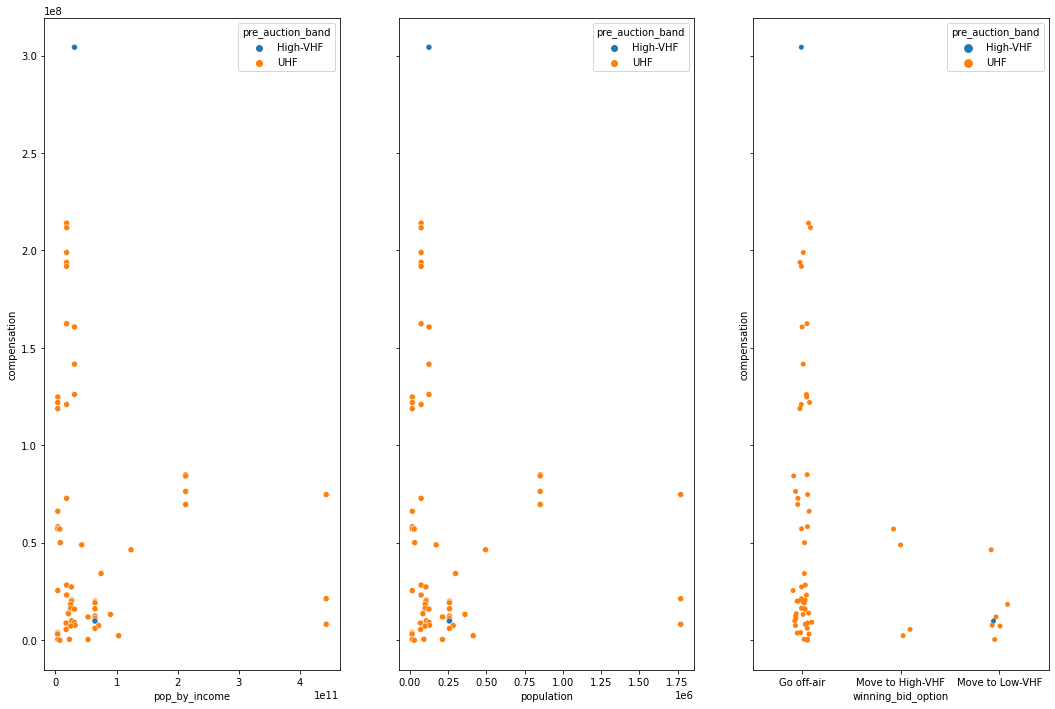

In [129]:
plot, axes = plt.subplots(1,3, figsize=(18,12), sharey=True)

#palette = sns.color_palette()
#sns.set_palette(palette=palette)

ax1 = sns.scatterplot(ax=axes[0], data=bidZipIncPop, x="pop_by_income", y="compensation", hue="pre_auction_band")
ax2 = sns.scatterplot(ax=axes[1], data=bidZipIncPop, x="population", y="compensation", hue="pre_auction_band")
ax3 = sns.stripplot(ax=axes[2], data=bidZipIncPop, x="winning_bid_option", y="compensation", hue="pre_auction_band")

fig = plot.get_figure()
fig.savefig("graphs/bid_scatters.png")

In [101]:
bidsByDma = (bidsByDma.rename({"bidder":"num_bidders"},axis=1))
bidsByDma.head()

,num_bidders
zipcode,
93599,12
18464,10
19980,10
26764,8
26865,8


In [102]:
bidPer = bidZipIncPop.merge(bidsByDma, how="outer", on="zipcode")
bidPer.to_csv("data/merged_bid_data.csv")
bidPer.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,bidder,frn,pre_auction_band,winning_bid_option,compensation,zipcode,income,population,pop_by_income,num_bidders
0,998,BLCDT20140709ACQ,WWTO-TV,10,LA SALLE,IL,DT,36292.7,34703.5,6246736,...,"Trinity Christian Center of Santa Ana, Inc.",3791712.0,High-VHF,Go off-air,304250040.0,61373.0,250000.0,124346.0,3.108650e+10,6
1,48772,BLCDT20050425ACE,WPWR-TV,51,GARY,IN,DT,36439.5,36347.1,10050152,...,"Fox Television Stations, LLC",5795067.0,UHF,Go off-air,160748259.0,61373.0,250000.0,124346.0,3.108650e+10,6
2,70119,BLCDT20111208AGI,WSNS-TV,45,CHICAGO,IL,DT,30773.5,30124.7,9828403,...,NBC Telemundo License LLC,19509470.0,UHF,Go off-air,141658837.0,61373.0,250000.0,124346.0,3.108650e+10,6
3,60539,BLCDT20101116BHE,WXFT-DT,50,AURORA,IL,DT,26323.3,25087.8,9559169,...,UniMas Chicago LLC,3770898.0,UHF,Go off-air,126107725.0,61373.0,250000.0,124346.0,3.108650e+10,6
4,12279,BLEDT20030501ABC,WYCC,21,CHICAGO,IL,DT,21046.9,20668.4,9271314,...,"BD TRUSTEES COMM COLLEGE DIST # 508, CTY COOK, IL",6754626.0,UHF,Go off-air,15959957.0,61373.0,250000.0,124346.0,3.108650e+10,6


In [103]:
if np.max(bidPer["compensation"] > 100000000):
    bidPer["compensation"] = bidPer["compensation"] / 1000000
bidPer = (
    bidPer.sort_values(["compensation", "num_bidders", "population"], ascending=False)
    .drop(["pop_by_income"], axis=1)
)
bidPer.head()

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,dma,bidder,frn,pre_auction_band,winning_bid_option,compensation,zipcode,income,population,num_bidders
0,998,BLCDT20140709ACQ,WWTO-TV,10,LA SALLE,IL,DT,36292.7,34703.5,6246736,...,"CHICAGO, IL","Trinity Christian Center of Santa Ana, Inc.",3791712.0,High-VHF,Go off-air,304.250040,61373.0,250000.0,124346.0,6
6,47535,BPCDT20080620ADL,WNBC,28,NEW YORK,NY,DT,32312.4,29112.7,20338490,...,"NEW YORK, NY",NBC Telemundo License LLC,19509470.0,UHF,Go off-air,214.023017,18464.0,250000.0,73040.0,10
7,74156,BLCDT20140925AFG,WRNN-TV,48,KINGSTON,NY,DT,33618.7,29044.9,16748933,...,"NEW YORK, NY","WRNN License Company, LLC",10622041.0,UHF,Go off-air,211.680472,18464.0,250000.0,73040.0,10
8,74215,BLCDT20050214AGS,WXTV-DT,40,PATERSON,NJ,DT,25552.7,22907.3,19476238,...,"NEW YORK, NY","WXTV License Partnership, G.P.",1531243.0,UHF,Go off-air,198.965211,18464.0,250000.0,73040.0,10
9,48477,BLEDT20061121ADG,WNJN,51,MONTCLAIR,NJ,DT,18048.9,16437.6,17655414,...,"NEW YORK, NY",New Jersey Public Broadcasting Authority,4368007.0,UHF,Go off-air,193.892273,18464.0,250000.0,73040.0,10


In [104]:
bidModel = LinearRegression(fit_intercept = True)

normalComp = (MinMaxScaler()
    .fit_transform(bidPer["compensation"][:66]
    .to_numpy()
    .reshape(-1,1)))

xVars = np.concatenate([bidPer["population"].values, 
                        bidPer["num_bidders"].values])

xVar = (bidPer["num_bidders"][:66]
    .to_numpy()
    .reshape(-1,1))
    
yVar = normalComp

bidModel.fit(X=xVar, y=yVar)
bidPredict = bidModel.predict(X=xVar)
print(f"Mean square error: {mean_squared_error(yVar, bidPredict)}")
print(f"Mean absolute error: {mean_absolute_error(yVar, bidPredict)}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(yVar, bidPredict)}")

Mean square error: 0.03636022878734446
Mean absolute error: 0.14540352891901176
Mean absolute percentage error: 5219771015852.512


In [134]:
ageCensus = pd.read_csv("data/age_census.csv", engine='pyarrow')

#ageCensus = ageCensus.iloc[1:,]
ageCensus["zipcode"] = ageCensus["NAME"].apply(lambda x: x.split()[1])

ageCensus = (pd.concat([ageCensus["zipcode"], ageCensus["S0101_C01_032E"]],axis=1)
            .iloc[1:,:]
            .rename({"S0101_C01_032E":"age"},axis=1)
)
ageCensus.zipcode = ageCensus.zipcode.astype(np.float64)

ageCensus["age"] = pd.to_numeric(ageCensus["age"], errors="coerce")

ageCensus.sort_values("age",ascending=False, inplace=True)
ageCensus.head()

,zipcode,age
169,1066.0,94.0
5816,18357.0,93.2
6414,20612.0,91.1
3901,13674.0,90.2
10069,30573.0,88.2


In [106]:
withAge = bidPer.merge(ageCensus, how="inner", on="zipcode")
withAge["income"] = pd.to_numeric(withAge["income"], errors="coerce")

withAge.to_csv("data/merged_bid_data.csv")
withAge.head(5)

,facility_id,FileNumber,Call,Ch,City,St,Type,Area,Area,Population,...,bidder,frn,pre_auction_band,winning_bid_option,compensation,zipcode,income,population,num_bidders,age
0,998,BLCDT20140709ACQ,WWTO-TV,10,LA SALLE,IL,DT,36292.7,34703.5,6246736,...,"Trinity Christian Center of Santa Ana, Inc.",3791712.0,High-VHF,Go off-air,304.250040,61373.0,250000.0,124346.0,6,44.8
1,48772,BLCDT20050425ACE,WPWR-TV,51,GARY,IN,DT,36439.5,36347.1,10050152,...,"Fox Television Stations, LLC",5795067.0,UHF,Go off-air,160.748259,61373.0,250000.0,124346.0,6,44.8
2,70119,BLCDT20111208AGI,WSNS-TV,45,CHICAGO,IL,DT,30773.5,30124.7,9828403,...,NBC Telemundo License LLC,19509470.0,UHF,Go off-air,141.658837,61373.0,250000.0,124346.0,6,44.8
3,60539,BLCDT20101116BHE,WXFT-DT,50,AURORA,IL,DT,26323.3,25087.8,9559169,...,UniMas Chicago LLC,3770898.0,UHF,Go off-air,126.107725,61373.0,250000.0,124346.0,6,44.8
4,12279,BLEDT20030501ABC,WYCC,21,CHICAGO,IL,DT,21046.9,20668.4,9271314,...,"BD TRUSTEES COMM COLLEGE DIST # 508, CTY COOK, IL",6754626.0,UHF,Go off-air,15.959957,61373.0,250000.0,124346.0,6,44.8


In [114]:
every = (pd.read_excel("data/everyZip.xlsx")
)

for c in every.columns:
    if "Unnamed" in c: every = every.drop(c, axis=1)
every.head()

,zipcode,State,dma,population,population_adult,age_median,population_child,computer_access,population_disabled,bachelors_higher_pct,...,obesity_pct,avg_house_age,median_hh_income,foodstamps,internet_access,poverty,Black,White,Female,Male
0,77494,TX,Houston TX,126310,0.666,36.1,42187,0.304,5883,0.628,...,0.282,15,168443,0.019,0.990,0.046,0.082,0.612,0.515,0.485
1,77449,TX,Houston TX,123157,0.694,32.9,37670,0.304,9076,0.283,...,0.333,21,88516,0.107,0.984,0.077,0.224,0.515,0.522,0.478
2,75034,TX,Dallas-Ft. Worth TX,116155,0.717,37.0,32910,0.356,7101,0.617,...,0.310,18,153302,0.026,0.987,0.045,0.078,0.676,0.514,0.486
3,90011,CA,Los Angeles CA,110750,0.701,29.6,33081,0.224,10737,0.069,...,0.359,65,58009,0.272,0.905,0.271,0.068,0.361,0.487,0.513
4,75070,TX,Dallas-Ft. Worth TX,109085,0.710,37.4,31610,0.346,7012,0.567,...,0.313,19,130535,0.012,0.987,0.042,0.095,0.705,0.513,0.487
